In [1]:
# ============================================================
# Notebook setup
# ============================================================

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

# Load data
data_folder = 'data/nab'
file_name = 'realTraffic/occupancy_6005.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

data_d = nab.densify(data, freq='5T')

# Filling Missing Values in Traffic Data

## Time to Tackle the Traffic Data

**Now that we've had some practice, let's _tackle the traffic data_**

We will start from the dense series:

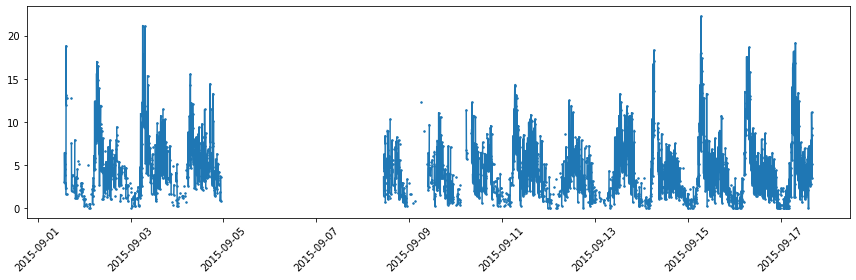

In [2]:
nab.plot_series(data_d, show_markers=True)

* There is a _period_, _non-zero mean_, local _oscillations_. And of course a _huge gap_

## Time and Period

**We want to learn a Gaussian Process, so we need to _add time information_**

We use once again the 1 step = 1 unit of time equivalence

In [3]:
data_dt = data_d.copy()
data_dt['time'] = np.arange(len(data_dt))

**Detecting the period is (in principle) more challenging**

Due to the missing values, the series has a _non-uniform sampling frequency_

* Autocorrelation plots cannot be used in this case
* The standard FFT is also not applicable (though we could use a [non-uniform FFT](https://en.wikipedia.org/wiki/Non-uniform_discrete_Fourier_transform))

**Thankfully, this is traffic data! So we can bet there is _a weekly period_**

## Process Outline

**We have no ground truth: how are we going to evaluate the kernels?**

Main idea: use _part of our data as a validation set_

* We will _focus on a portion_ of our sequence
    * ...One with relatively few missing values
* Then we will _artificially remove_ part of the data points
    * This will form the ground truth for our evaluation

**We will not use the MSE as a quality metric**

* Thanks to the availability of confidence intervals...
* ...We can compute the _likelihood_ of our validation set (its _estimated_ probability)!
* The MSE would do the same, only with _uniform variance_

## Training and Validation Data

**We we use for training (and validation) this stretch of the series**

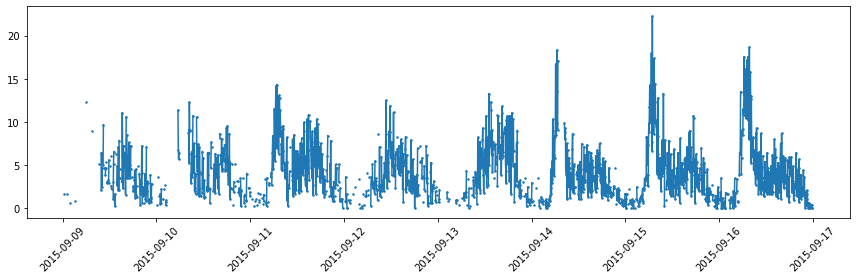

In [4]:
segment = data_dt[(data_dt.index >= '2015-09-09') & (data_dt.index < '2015-09-17')].copy()
nab.plot_series(segment['value'], show_markers=True)

* We made sure to include _at least one full week_

## Training and Validation Data

**We can now separate training and validation data:**

In [5]:
np.random.seed(42)
idx = np.arange(len(segment))
np.random.shuffle(idx[1:-1]) # keep first and last in their positionn

sep = 2*len(idx) // 3
trdata = segment.iloc[idx[:sep]].dropna()
tsdata = segment.iloc[idx[sep:]].dropna()

**We are keeping 2/3 of the data for training**

* Since we are using the dense series, we need to discard NaNs (`dropna`)
* We are not going to use the basic interpolation approaches...
* ...So, there is no need to force the inclusion of the first/last point in the training set

## A Starting Kernel

**Let's try with a relatively simple kernel**

In [6]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value'])
print(gp.kernel_)

WhiteKernel(noise_level=0.1) + 4.79**2 * RBF(length_scale=1.01)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Then we obtain the predictions:

In [7]:
pred, std = gp.predict(segment[['time']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

## A Starting Kernel

**Let's have a look at the predictions**

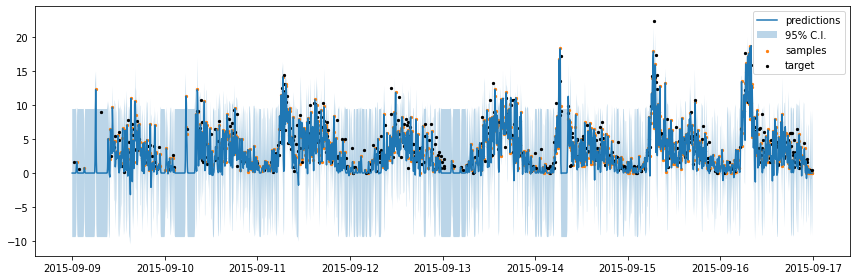

In [8]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

* Not bad, but _very wide C.I._

## A Starting Kernel

**Let's compute the (log) likelihood of the validation data**

In [9]:
from scipy.stats import norm

# Obtain predictions for the validation data
pred_ts = pred[tsdata.index]
std_ts = std[tsdata.index]

ldens = norm.logpdf(tsdata['value'], pred_ts, std_ts)
ll = np.sum(ldens)
print(f'Log likelihood of the validation set: {ll:.2f}')

Log likelihood of the validation set: -1417.05


* This is our reference value
* We will try to beat it by _improving the kernel_

## A Second Kernel

**Let's add _the period_**

In [10]:
kernel = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (1900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(trdata[['time']], trdata['value'])
print(gp.kernel_)

WhiteKernel(noise_level=0.0988) + 2.02**2 * RBF(length_scale=0.404) + 4.62**2 * ExpSineSquared(length_scale=0.1, periodicity=2.01e+03)


/usr/local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Then we repeat training:

In [11]:
pred, std = gp.predict(segment[['time']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

## A Second Kernel

**Both predictions and likelihood are now better** (but the C.I. are still large)

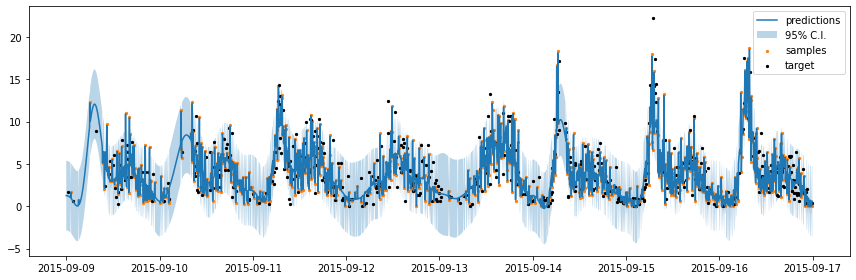

In [12]:
nab.plot_gp(target_samples=tsdata['value'], samples=trdata['value'], pred=pred, std=std)

In [13]:
ldens = norm.logpdf(tsdata['value'], pred[tsdata.index], std[tsdata.index])
print(f'Log likelihood of the validation set: {np.sum(ldens):.2f}')

Log likelihood of the validation set: -1154.54


## Transferring the Results

**We now need to obtain predictions _for the whole series_**

We would prefer to _avoid training again the kernel_ parameters

* The large number of missing value may be problematic
* ...And the training time would be very large

We really wish to use _all available observations_

* ...Not just those considered when training the kernel

**With Gaussian Processes, we can do both**

There is _no need to train again the kernel_ every time new observations arrive

* We can build a new $\Sigma$ matrix using the new observations and the old kernel

## Transferring the Results

**We reuse the kernel by passing it as argument when building a new G.P.:**

In [14]:
gp2 = GaussianProcessRegressor(kernel=gp.kernel_, optimizer=None)

* Passing `optimizer=None` will _disable optimization_ at training time
* ...So that calling `fit` will just take into account _a new set of observations_

In [15]:
tmp = data_dt.dropna() # The whole series (NaNs excluded)
gp2.fit(tmp[['time']], tmp['value']);

Now we can obtain predictions for the whole series:

In [16]:
pred_all, std_all = gp2.predict(data_dt[['time']], return_std=True)
pred_all = pd.Series(index=data_dt.index, data=pred_all)
std_all = pd.Series(index=data_dt.index, data=std_all)

## Transferring the Results

**Let's have a look at all the predictions**

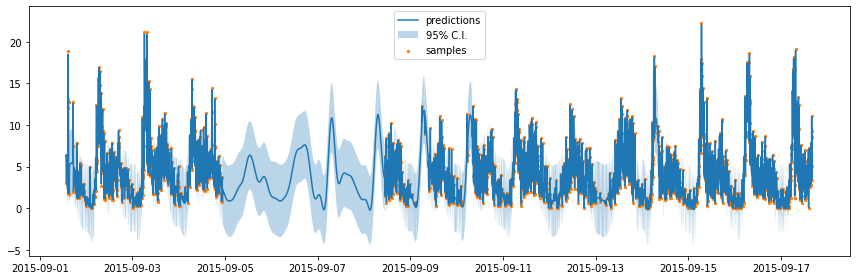

In [17]:
nab.plot_gp(samples=data_dt['value'], pred=pred_all, std=std_all)

* We actually managed to (partially) reconstruct _even the large gap_!

## Transferring the Results

**The confidence intervals are still very large**

* This is in part understandable, give the presence of wide variations
* ...But at least one point is a bit strange

**The confidence intervals are large _even for the night hours_!**

There are two reasons:

* There are _fewer samples_ at nighttime
    * As we get far from the samples the confidence drops (quickly, in our case)
* No traditional G.P. kernel can represent _point-wise, input-dependent variance_
    * All kernels are about covariance, not variance
    * The lone exception is the `WhiteKernel`, which is not input dependent

**Can we deal with this issues?**

# Standard Deviation Model

## Multiplicative Ensemble

**We can deal with the input-dependent variance _in a separate model_**

Once, again we are going to build an _ensemble_ of predictive models

* In the case of differencing, the ensemble was a sum
* But that's not going to work with variance, since:

$$
\mathit{Var}(x + \alpha) = \mathit{Var}(x)
$$

**However, variance can be _scaled via multiplication_:**

In particular:

$$
\mathit{Var}(\alpha x) = \alpha^2 \mathit{Var}(x)
$$

* So we can use _a "multiplicative" ensemble_

## Multiplicative Ensemble

**Our model will become _the product of two models_**

Formally, we will have:

$$ 
g(x, \lambda) f(x, \theta)
$$

* $f$, with parameters $\theta$ will be a Gaussian Process
* $g$, with parameters $\lambda$ will be our _variance model_ (or _standard deviation model_)

**On the training set, we wish to have:**

$$
g(\hat{x}_i, \lambda) f(\hat{x}_i, \theta) \simeq \hat{y}_i \quad\Rightarrow\quad f(\hat{x}_i, \theta) \simeq \frac{\hat{y}_i}{g(\hat{x}_i, \lambda)}
$$

* The Gaussian Process will need to learn a series with a variance _altered by $g$_
* The variance of each point $\hat{y}_i$ will be divided by $g(\hat{x}_i, \lambda)^2$


## Standard Deviation Model

**We now need to choose our variance model $g$**

* Since we have discrete time and a natural period (a week)
* ...We could use a simple map (time of the week $\rightarrow$ standard deviation)

**Let's add a "hour of the week" information to our data:**

The chosen time unit is actually irrelevant

In [18]:
data_dtw = data_dt.copy()
data_dtw['how'] = 24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60
data_dtw.head()

,value,time,how
2015-09-01 13:45:00,3.06,0,37.750000
2015-09-01 13:50:00,6.44,1,37.833333
2015-09-01 13:55:00,5.17,2,37.916667
2015-09-01 14:00:00,3.83,3,38.000000
2015-09-01 14:05:00,4.50,4,38.083333


## Standard Deviation Model

**Then we can compute the standard deviation via a pandas `groupby` operation:**

In [19]:
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

* `agg` allows to apply multiple aggregation functions to multiple columns

**The resulting table has a _hierarchical column index_**

Let's see some statistics about the value counts:

In [20]:
how_std['value', 'count'].describe() # Notice the use of two names

count    2016.000000
mean        1.176091
std         0.851356
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: (value, count), dtype: float64

## Standard Deviation Model

**Let's have a look at the standard deviation values**

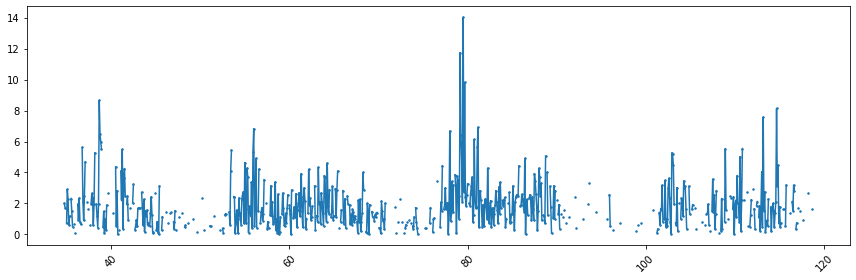

In [21]:
nab.plot_series(how_std['value', 'std'], show_markers=True)

There are _many missing values_ (as expected from the counts)!

## Choosing the Correct Interval

**There are too many gaps in our data to compute $\sigma$ with this granularity**

There are a few possible solutions:

* _Filling the gaps_ also in the standard deviation data
* ...Or using _a coarser time unit_
* ...Or choosing _a shorter period_ (e.g. one day)

**Let's try using hour-long intervals (rather than 5 minutes)**

In [22]:
data_dtw = data_dt.copy()
data_dtw['how'] = np.round(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60)
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

* We need to check that _no std value is missing_
* ...But also that _the counts are large enough_ for a reliable computation

## Choosing the Correct Interval

**Let's look again at the standard deviation values**

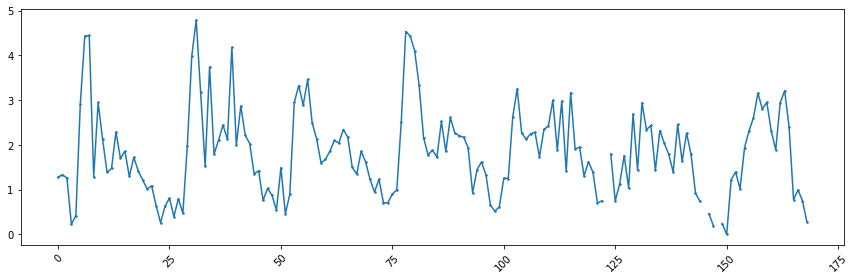

In [23]:
nab.plot_series(how_std['value', 'std'], show_markers=True)

* There are _still a few gaps_

## Choosing the Correct Interval

**...And let's see the value counts**

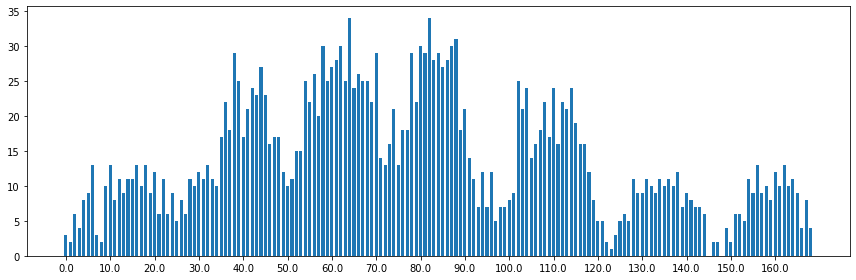

In [24]:
nab.plot_bars(how_std['value', 'count'])

* Several value counts are too low for $\sigma$ to be reliable

## Choosing the Correct Interval

**We can try again with two-hour intervals**

In [25]:
data_dtw = data_dt.copy()
data_dtw['how'] = 2*np.round(0.5*(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60))
how_std = data_dtw.groupby('how').agg({'value': ['std', 'count']})

**Let's check some information about the value counts:**

* Ideally, we wish them at $\sim 30$

In [26]:
how_std['value', 'count'].describe()

count    85.000000
mean     27.894118
std      16.138554
min       3.000000
25%      16.000000
50%      22.000000
75%      42.000000
max      63.000000
Name: (value, count), dtype: float64

## Choosing the Correct Interval

**Let's look the standard deviation with two-hour intervals**

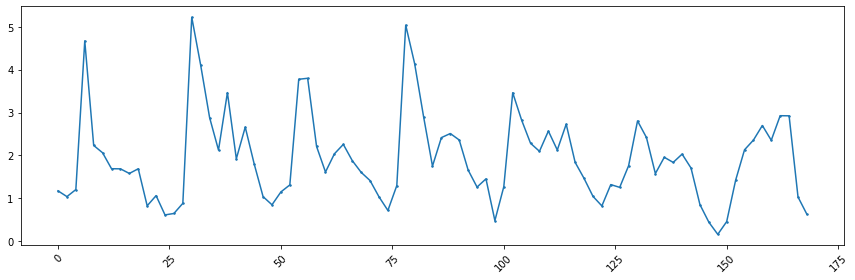

In [27]:
nab.plot_series(how_std['value', 'std'], show_markers=True)

* Finally, _no more missing values_ and _decently large counts_

## Upsampling and Smoothing

**We managed to have reasonable standard deviation values..**

...But out map/table has a _very_ coarse time unit!

* Using it would lead to _sharp variations_ in our predicted standard deviation

**We will now proceed to mitigate the problem**

We will start by _upsampling_, i.e. switching to a finer grain time unit:

In [28]:
how_values = np.unique(24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60)
how_std_d = pd.DataFrame(index=sorted(how_values), columns=['std'], data=np.nan)
how_std_d['std'] = how_std['value', 'std']

This process leads to many missing values, that we fill via _linear interpolation_:

In [29]:
how_std_di = how_std_d.interpolate(method='linear')

## Upsampling and Smoothing

**Let's see the oversampled series**

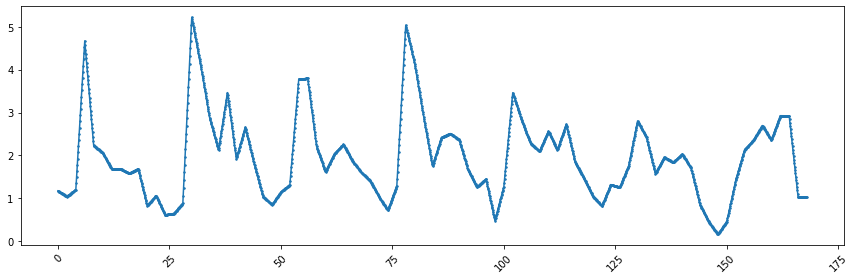

In [30]:
nab.plot_series(how_std_di['std'], show_markers=True)

* The plot is the _same as before_, but there are _many more samples_

## Upsampling and Smoothing

**Next, we apply an Exponentially Weighted Moving Average**

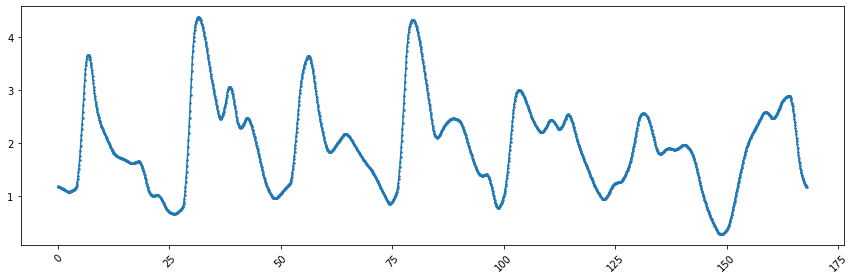

In [31]:
how_std_ds = how_std_di[['std']].ewm(com=12).mean()
nab.plot_series(how_std_ds['std'], show_markers=True)

* We chose $\tau = $ the number of time steps in one hour

# Gaussian Process for the Ensemble

## Transforming the Dataset

**We can now learn the Gaussian Process for our Ensemble**

For this, we need to _transform the original series_ using the standard deviation model

* We start by augmenting our dataset with the "hour of the week information"
* ...Then, we associate each data point to the predicted standard deviation

In [32]:
data_dt['how'] = 24 * data_dt.index.weekday + data_dt.index.hour + data_dt.index.minute / 60
data_dts = data_dt.join(how_std_ds, on='how')
data_dts.head()

,value,time,how,std
2015-09-01 13:45:00,3.06,0,37.750000,2.827427
2015-09-01 13:50:00,6.44,1,37.833333,2.867852
2015-09-01 13:55:00,5.17,2,37.916667,2.909461
2015-09-01 14:00:00,3.83,3,38.000000,2.952163
2015-09-01 14:05:00,4.50,4,38.083333,2.986639


* We relied on the [`join` method from `pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html)

## Transforming the Dataset

**Now we can actually transform the series values**

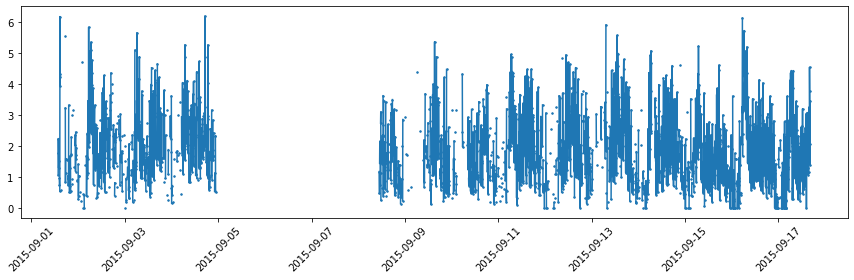

In [33]:
data_dts['value'] = data_dts['value'] / data_dts['std']
nab.plot_series(data_dts['value'], show_markers=True)

* The series _has changed considerably_: this is not a simple standardization

## Training Data

**We can now select a sub-sequence of the data for learning the kernel**

...Which is necessary, since the data has changed!

In [34]:
segment_s = data_dts[(data_dts.index >= '2015-09-09') & (data_dts.index < '2015-09-17')].copy()

We separate training and validation data as we did  before:

In [35]:
np.random.seed(42)
idx_s = np.arange(len(segment_s))
np.random.shuffle(idx[1:-1])

sep_s = 2*len(idx_s) // 3
trdata_s = segment_s.iloc[idx[:sep_s]].dropna()
tsdata_s = segment_s.iloc[idx[sep_s:]].dropna()

## Learning the Kernel Parameters

**We can now learn the kernel parameters**

We can use the same starting parameters (_priors_) as before:

In [ ]:
kernel_s = WhiteKernel(1e-3, (1e-4, 1e-1))
kernel_s += ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-1, 1e1))
kernel_s += ConstantKernel(1, (1e-2, 1e2)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (1900, 2100))

np.random.seed(42)
gp_s = GaussianProcessRegressor(kernel=kernel_s, n_restarts_optimizer=3)
gp_s.fit(trdata_s[['time']], trdata_s['value'])
print(gp_s.kernel_)

Then we obtain the predictions:

In [ ]:
pred_s, std_s = gp_s.predict(segment_s[['time']], return_std=True)
pred_s = pd.Series(index=segment_s.index, data=pred_s)
std_s = pd.Series(index=segment_s.index, data=std_s)

## Learning the Kernel Parameters

**Let's look at the predictions on the training data**

In [ ]:
nab.plot_gp(target_samples=tsdata_s['value'], samples=trdata_s['value'], pred=pred_s, std=std_s)

* For sake of simplicity, we will not try to improve the kernel

## Transferring the Results

**Now we can obtain predictions for the missing values in the _transformed_ series**

Again, we reuse the kernel and add the observations:

In [45]:
gp2_s = GaussianProcessRegressor(kernel=gp_s.kernel_, optimizer=None)
tmp_s = data_dts.dropna() # The whole series (NaNs excluded)
gp2_s.fit(tmp_s[['time']], tmp_s['value']);

Then we can obtain predictions (and confidence intervals) for the whole series

In [46]:
pred_all_s, std_all_s = gp2_s.predict(data_dts[['time']], return_std=True)
pred_all_s = pd.Series(index=data_dts.index, data=pred_all_s)
std_all_s = pd.Series(index=data_dts.index, data=std_all_s)

* Of course are still referring to the transformed series

## Transferring the Results

**Let's have a look at all the predictions**

In [47]:
nab.plot_gp(samples=data_dts['value'], pred=pred_all_s, std=std_all_s)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* They are not so easy to interpret, since they refer to the transformed series

## Predictions for the Original Series

**We can obtain predictions _for the original series_ by injecting back the variance**

In [48]:
pred_all2_s = pd.Series(index=data_dts.index, data=pred_all_s * data_dts['std'])
std_all2_s = pd.Series(index=data_dts.index, data=std_all_s * data_dts['std'])
nab.plot_gp(samples=data_dt['value'], pred=pred_all2_s, std=std_all2_s)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* Due to the properties of variance, we can _just multiply also the standard deviation_

## Predictions for the Original Series

**For comparison, here are the results for the previous Gaussian Process**

In [49]:
nab.plot_gp(samples=data_dt['value'], pred=pred_all, std=std_all) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* The new confidence intervals are _much tighter_

## Fill with Predictions and Samples

**We can fill the missing values using the _predictions_**

This will fill each missing value using the Maximum A Posteriori

In [50]:
mask = data_d['value'].isnull() # we need to fill only the NaNs
data_filled_pred = data_d.copy()
data_filled_pred.loc[mask, 'value'] = np.maximum(0, pred_all2_s[mask])

**But we can also _sample from the distribution_**

In [51]:
tmp = data_dts[mask]
sample_ms = gp2_s.sample_y(tmp[['time']], random_state=42).ravel()
data_filled_samples = data_d.copy()
data_filled_samples.loc[mask, 'value'] = np.maximum(0, sample_ms * tmp['std'])

* `sample_y` returns a matrix: we used `ravel` to have a single dimension
* In both cases, we _clip values at zero_ (no less than 0 occupancy)

## Filling with Predictions and Samples

**Here's the series filled _using predictions_:**

In [52]:
nab.plot_series(data_filled_pred)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* The use of MAPs is evident in the large gap

## Filling with Predictions and Samples

**Here's the series filled _using samples_:**

In [53]:
nab.plot_series(data_filled_samples)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* There no evidently "fake" sections, now! ...Except for the effect of clipping at 0

## Considerations

**Congratulations, you have cleaned your data!**

* ...But _it wasn't an easy feat_, right?
* To be fair, this was a challenging problem
* ...But still, in practice, cleaning the data often takes _a large chuck of the project time_

**Multiplying the results of different models**

* Is a _third approach_ to obtain an _ensemble_ (besides switching and addition)
* Unlike an addition, using a product _changes the variance_ of the data
* This is good news if you main model is having trouble with that
* ...But it may lead to nasty surprises if you are not aware of that


## Open Questions

> **We had multiple options for our trouble with the computation of $\sigma$**. We chose to employ _a more coarse grained time unit_: what would happen by focusing instead on _a shorter period_ (say, one day instead of one week)?